# Tumor Tracer
## Codigo hecho por Aimé Moral y Gabriel Juan
### El codigo esta separado en dos partes

#### Parte 1: Machine Learning
Tomaremos cada fotos, sin importar el paciente, extraeremos el contorno del cancer y compararemos con la respuesta del dataset

#### Parte 2: Deep Learning
Agruparemos las fotos por paciente, extraeremos los concornos de cada nivel, de forma ordenada. Una vez se tienen todo, se hara una nuve de puntos 3D donde se podra ver el centro del cluster y al ir comparando capa a capa, se podra ver si alguna capa no se ha detectado de una forma coherente con respecto al resto de capas

In [3]:
%pip install numpy opencv-python pandas matplotlib scikit-learn scikit-image scipy seaborn tensorflow keras albumentations

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\UAB\3º 1º\APC\APC_Cass_Kaggle\Tumor-Tracer\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\UAB\3º 1º\APC\APC_Cass_Kaggle\Tumor-Tracer\venv\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl (11.3 MB)
  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl (8.1 MB)
  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
  Using cached scikit_image-0.25.2-cp310-cp310-win_amd64.whl (12.8 MB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl (41.3 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl (331.7 MB)
  Using cached keras-3.12.0-py3-none-any.whl (1.5 MB)
  Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pillow-12.0.0-cp310-cp310-win_amd64.whl (7.0 MB)
  Using cached pyparsing-3.2.5-py3-none-any.whl (11

In [8]:
#Librerias

import numpy as np
import cv2
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from tqdm.notebook import tqdm
import random
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, jaccard_score
)
import seaborn as sns

In [ ]:
import shutil
# Redefinicion de las carpetas
# Rutas de configuración
ORIGINAL_DATASET_PATH = "../data/kaggle_3m/"  # Donde están las carpetas ahora
NEW_FLAT_PATH = "../data/dataset_plano/"      # Donde las quieres poner

# 1. Crear la carpeta nueva si no existe
if not os.path.exists(NEW_FLAT_PATH):
    os.makedirs(NEW_FLAT_PATH)
    print(f"Carpeta creada: {NEW_FLAT_PATH}")

print("--- Iniciando migración de archivos ---")

# 2. Buscar todos los archivos .tif en subcarpetas
# En Windows usamos '**/*.tif' con recursive=True
files = glob.glob(os.path.join(ORIGINAL_DATASET_PATH, '**', '*.tif'), recursive=True)

count = 0
for file_path in files:
    # Obtener solo el nombre del archivo (ej: TCGA_CS_4941_19960909_1.tif)
    filename = os.path.basename(file_path)
    
    # Definir la nueva ruta de destino
    dst_path = os.path.join(NEW_FLAT_PATH, filename)
    
    # Evitar sobrescribir si ya existe
    if not os.path.exists(dst_path):
        # Copiar el archivo (usamos copy2 para preservar metadatos)
        shutil.copy2(file_path, dst_path)
        count += 1

print(f"--- Proceso terminado ---")
print(f"Se han copiado {count} imágenes a '{NEW_FLAT_PATH}'")

--- Iniciando migración de archivos ---
--- Proceso terminado ---
Se han copiado 0 imágenes a '../data/dataset_plano/'


## Configuracion y Feature engineering

In [9]:
# Ajusta esta ruta a donde tengas descomprimido tu dataset
DATASET_PATH = "../data/dataset_plano/" 

def extract_features(img):
    """
    Esta función toma una imagen y crea un DataFrame donde cada fila
    es un píxel y cada columna es una característica (feature) extraída
    usando filtros clásicos.
    """
    df = pd.DataFrame()
    
    # Imagen original (1D array)
    img2 = img.reshape(-1)
    df['Original Image'] = img2

    # Feature 1: Gabor Filter (Textura)
    # Generamos varios filtros Gabor con diferentes orientaciones/tamaños
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            lamda = np.pi / 4
            gamma = 0.5
            ksize = 9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            df[f'Gabor_{num}'] = filtered_img
            num += 1

    # Feature 2: Canny Edge (Bordes)
    edges = cv2.Canny(img, 100, 200)
    df['Canny Edge'] = edges.reshape(-1)

    # Feature 3: Roberts Edge
    edge_roberts = roberts(img)
    df['Roberts'] = edge_roberts.reshape(-1)

    # Feature 4: Sobel
    edge_sobel = sobel(img)
    df['Sobel'] = edge_sobel.reshape(-1)

    # Feature 5: Gaussian Blur (para suavizado/vecindad)
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    df['Gaussian'] = gaussian_img.reshape(-1)

    return df

def get_contours(mask):
    """
    Obtiene los contornos de una máscara binaria.
    """
    # Asegurarse de que sea uint8
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def calculate_iou(y_true, y_pred):
    """
    Calcula Intersection over Union (Jaccard Score).
    Es la métrica estándar para segmentación.
    """
    # Aplanar para comparar
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    # Usamos average='binary' asumiendo 0 fondo, 1 tumor
    return jaccard_score(y_true, y_pred, average='binary')

## ENTRENAMIENTO DEL MODELO (Pequeño ejemplo)
Para ML Clásico, no podemos entrenar con TODAS las fotos a la vez en RAM fácilmente. Seleccionamos algunas imágenes representativas para entrenar.

In [10]:


print("--- Buscando imágenes ---")
# Patrón para encontrar imágenes y máscaras
all_tif_files = glob.glob(os.path.join(DATASET_PATH, '*.tif'))

# Separamos: máscaras terminan en _mask.tif, imágenes NO terminan en _mask.tif
mask_paths = [f for f in all_tif_files if f.endswith('_mask.tif')]
image_paths = [f for f in all_tif_files if not f.endswith('_mask.tif')]

# Crear pares imagen-máscara válidos
valid_pairs = []
for img_path in image_paths:
    # Derivar la ruta de la máscara correspondiente
    mask_path = img_path.replace('.tif', '_mask.tif')
    if os.path.exists(mask_path):
        valid_pairs.append((img_path, mask_path))

print(f"Encontrados {len(valid_pairs)} pares imagen-máscara válidos")

# ==========================================
# SELECCIÓN ALEATORIA DE 500 IMÁGENES
# ==========================================
random.seed(42)  # Para reproducibilidad
sample_size = min(500, len(valid_pairs))  # 500 o menos si no hay suficientes
selected_pairs = random.sample(valid_pairs, sample_size)

print(f"Seleccionadas {sample_size} imágenes al azar")

# Separar en listas
selected_images = [p[0] for p in selected_pairs]
selected_masks = [p[1] for p in selected_pairs]

# ==========================================
# SPLIT TRAIN/TEST (80/20)
# ==========================================
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    selected_images, selected_masks, 
    test_size=0.2, 
    random_state=42
)

print(f"Train: {len(train_imgs)} imágenes | Test: {len(test_imgs)} imágenes")

# ==========================================
# EXTRACCIÓN DE CARACTERÍSTICAS
# ==========================================
print(f"\n--- Extrayendo características de {len(train_imgs)} imágenes de entrenamiento ---")

X_list = []
Y_list = []

for img_path, mask_path in tqdm(zip(train_imgs, train_masks), total=len(train_imgs), desc="Extrayendo features"):
    # Lectura en escala de grises
    img = cv2.imread(img_path, 0) 
    mask = cv2.imread(mask_path, 0)
    
    if img is None or mask is None:
        continue
    
    # Normalizar máscara a 0 y 1
    mask = mask // 255 

    # Extraer características de todas las imágenes (con o sin tumor)
    features = extract_features(img)
    X_list.append(features)
    Y_list.append(mask.reshape(-1))

if len(X_list) == 0:
    print("Error: No se pudieron cargar imágenes.")
    exit()

# Concatenar todos los datos
X_prev = pd.concat(X_list)
Y_prev = np.concatenate(Y_list)

print(f"Dataset de entrenamiento: {X_prev.shape[0]} píxeles, {X_prev.shape[1]} características")
print(f"Distribución de clases: No Tumor={np.sum(Y_prev==0)}, Tumor={np.sum(Y_prev==1)}")


--- Buscando imágenes ---
Encontrados 3929 pares imagen-máscara válidos
Seleccionadas 500 imágenes al azar
Train: 400 imágenes | Test: 100 imágenes

--- Extrayendo características de 400 imágenes de entrenamiento ---
Encontrados 3929 pares imagen-máscara válidos
Seleccionadas 500 imágenes al azar
Train: 400 imágenes | Test: 100 imágenes

--- Extrayendo características de 400 imágenes de entrenamiento ---


--- Buscando imágenes ---
Encontrados 3929 pares imagen-máscara válidos
Seleccionadas 500 imágenes al azar
Train: 400 imágenes | Test: 100 imágenes

--- Extrayendo características de 400 imágenes de entrenamiento ---
Encontrados 3929 pares imagen-máscara válidos
Seleccionadas 500 imágenes al azar
Train: 400 imágenes | Test: 100 imágenes

--- Extrayendo características de 400 imágenes de entrenamiento ---


Extrayendo features:   0%|          | 0/400 [00:00<?, ?it/s]

--- Buscando imágenes ---
Encontrados 3929 pares imagen-máscara válidos
Seleccionadas 500 imágenes al azar
Train: 400 imágenes | Test: 100 imágenes

--- Extrayendo características de 400 imágenes de entrenamiento ---
Encontrados 3929 pares imagen-máscara válidos
Seleccionadas 500 imágenes al azar
Train: 400 imágenes | Test: 100 imágenes

--- Extrayendo características de 400 imágenes de entrenamiento ---


Extrayendo features:   0%|          | 0/400 [00:00<?, ?it/s]

Dataset de entrenamiento: 26214400 píxeles, 9 características
Distribución de clases: No Tumor=25923623, Tumor=290777


In [12]:
# ==========================================
# CROSS-VALIDATION CON K-FOLD (k=7)
# ==========================================
print("\n--- Realizando Cross-Validation con K-Fold (k=7) ---")

try:
    from cuml.ensemble import RandomForestClassifier as cuRF
    from cuml.model_selection import cross_val_score as cu_cross_val_score
    import cudf
    USE_GPU = True
    print("✅ CUDA detectado - Usando GPU (RAPIDS cuML)")
except ImportError:
    USE_GPU = False
    print("⚠️ RAPIDS no disponible - Usando CPU (scikit-learn)")
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier

# Submuestreo para cross-validation (usar todos los píxeles es muy costoso)
# Tomamos una muestra estratificada para CV
sample_cv_size = min(100000, len(Y_prev))  # Máximo 100k píxeles para CV
indices = np.random.choice(len(Y_prev), sample_cv_size, replace=False)
X_cv = X_prev.iloc[indices]
Y_cv = Y_prev[indices]

print(f"Usando {sample_cv_size} píxeles para cross-validation")

# Definir K-Fold
kfold = KFold(n_splits=7, shuffle=True, random_state=42)

if USE_GPU:
    # Convertir a cuDF para GPU
    X_cv_gpu = cudf.DataFrame(X_cv)
    Y_cv_gpu = cudf.Series(Y_cv)
    
    cv_model = cuRF(n_estimators=50, max_depth=10, random_state=42)
    # cuML no tiene cross_val_score directo, hacemos manual
    cv_scores = []
    for train_idx, val_idx in kfold.split(X_cv):
        cv_model.fit(X_cv_gpu.iloc[train_idx], Y_cv_gpu.iloc[train_idx])
        preds = cv_model.predict(X_cv_gpu.iloc[val_idx])
        cv_scores.append(f1_score(Y_cv[val_idx], preds.to_numpy()))
    cv_scores = np.array(cv_scores)
else:
    # Modelo para CV
    cv_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    # Ejecutar cross-validation
    cv_scores = cross_val_score(cv_model, X_cv, Y_cv, cv=kfold, scoring='f1', n_jobs=-1)



print(f"\n📊 Resultados Cross-Validation (7-Fold):")
print(f"   F1-Scores por fold: {[f'{s:.4f}' for s in cv_scores]}")
print(f"   F1-Score promedio:  {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# ==========================================
# ENTRENAMIENTO DEL MODELO FINAL
# ==========================================
print("\n--- Entrenando modelo final con todos los datos de train ---")

if USE_GPU:
    X = cudf.DataFrame(X_prev)
    Y = cudf.Series(Y_prev)
    model = cuRF(n_estimators=50, max_depth=10, random_state=42)
    model.fit(X, Y)
else:
    n_trees = 50
    batch_size = 10  # Entrenar 10 árboles en paralelo por iteración

    model = RandomForestClassifier(n_estimators=batch_size, max_depth=10, random_state=42, n_jobs=-1, warm_start=True)
    X = X_prev
    Y = Y_prev

    for i in tqdm(range(batch_size, n_trees + 1, batch_size), desc="Entrenando árboles"):
        model.n_estimators = i
        model.fit(X, Y)

print("--- Modelo Entrenado Exitosamente ---")

# Guardar referencias para la evaluación
subset_size = len(train_imgs)  # Para compatibilidad con celdas posteriores
image_paths = train_imgs + test_imgs
mask_paths = train_masks + test_masks


--- Realizando Cross-Validation con K-Fold (k=7) ---
Usando 100000 píxeles para cross-validation
Usando 100000 píxeles para cross-validation

📊 Resultados Cross-Validation (7-Fold):
   F1-Scores por fold: ['0.1633', '0.1616', '0.1556', '0.1272', '0.1461', '0.1429', '0.1538']
   F1-Score promedio:  0.1501 (+/- 0.0232)

--- Entrenando modelo final con todos los datos de train ---

📊 Resultados Cross-Validation (7-Fold):
   F1-Scores por fold: ['0.1633', '0.1616', '0.1556', '0.1272', '0.1461', '0.1429', '0.1538']
   F1-Score promedio:  0.1501 (+/- 0.0232)

--- Entrenando modelo final con todos los datos de train ---



--- Realizando Cross-Validation con K-Fold (k=7) ---
Usando 100000 píxeles para cross-validation
Usando 100000 píxeles para cross-validation

📊 Resultados Cross-Validation (7-Fold):
   F1-Scores por fold: ['0.1633', '0.1616', '0.1556', '0.1272', '0.1461', '0.1429', '0.1538']
   F1-Score promedio:  0.1501 (+/- 0.0232)

--- Entrenando modelo final con todos los datos de train ---

📊 Resultados Cross-Validation (7-Fold):
   F1-Scores por fold: ['0.1633', '0.1616', '0.1556', '0.1272', '0.1461', '0.1429', '0.1538']
   F1-Score promedio:  0.1501 (+/- 0.0232)

--- Entrenando modelo final con todos los datos de train ---


Entrenando árboles:   0%|          | 0/5 [00:00<?, ?it/s]


--- Realizando Cross-Validation con K-Fold (k=7) ---
Usando 100000 píxeles para cross-validation
Usando 100000 píxeles para cross-validation

📊 Resultados Cross-Validation (7-Fold):
   F1-Scores por fold: ['0.1633', '0.1616', '0.1556', '0.1272', '0.1461', '0.1429', '0.1538']
   F1-Score promedio:  0.1501 (+/- 0.0232)

--- Entrenando modelo final con todos los datos de train ---

📊 Resultados Cross-Validation (7-Fold):
   F1-Scores por fold: ['0.1633', '0.1616', '0.1556', '0.1272', '0.1461', '0.1429', '0.1538']
   F1-Score promedio:  0.1501 (+/- 0.0232)

--- Entrenando modelo final con todos los datos de train ---


Entrenando árboles:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

--- Evaluando modelo en conjunto de test ---


Evaluando:   0%|          | 0/20 [00:00<?, ?it/s]


MÉTRICAS DE CLASIFICACIÓN (PÍXEL A PÍXEL)

📊 Accuracy:  0.9896
📊 Precision: 0.7171
📊 Recall:    0.4375
📊 F1-Score:  0.5435
📊 Mean IoU:  0.3141

REPORTE DE CLASIFICACIÓN DETALLADO

📊 Accuracy:  0.9896
📊 Precision: 0.7171
📊 Recall:    0.4375
📊 F1-Score:  0.5435
📊 Mean IoU:  0.3141

REPORTE DE CLASIFICACIÓN DETALLADO
              precision    recall  f1-score   support

    No Tumor       0.99      1.00      0.99   1292136
       Tumor       0.72      0.44      0.54     18584

    accuracy                           0.99   1310720
   macro avg       0.85      0.72      0.77   1310720
weighted avg       0.99      0.99      0.99   1310720

              precision    recall  f1-score   support

    No Tumor       0.99      1.00      0.99   1292136
       Tumor       0.72      0.44      0.54     18584

    accuracy                           0.99   1310720
   macro avg       0.85      0.72      0.77   1310720
weighted avg       0.99      0.99      0.99   1310720



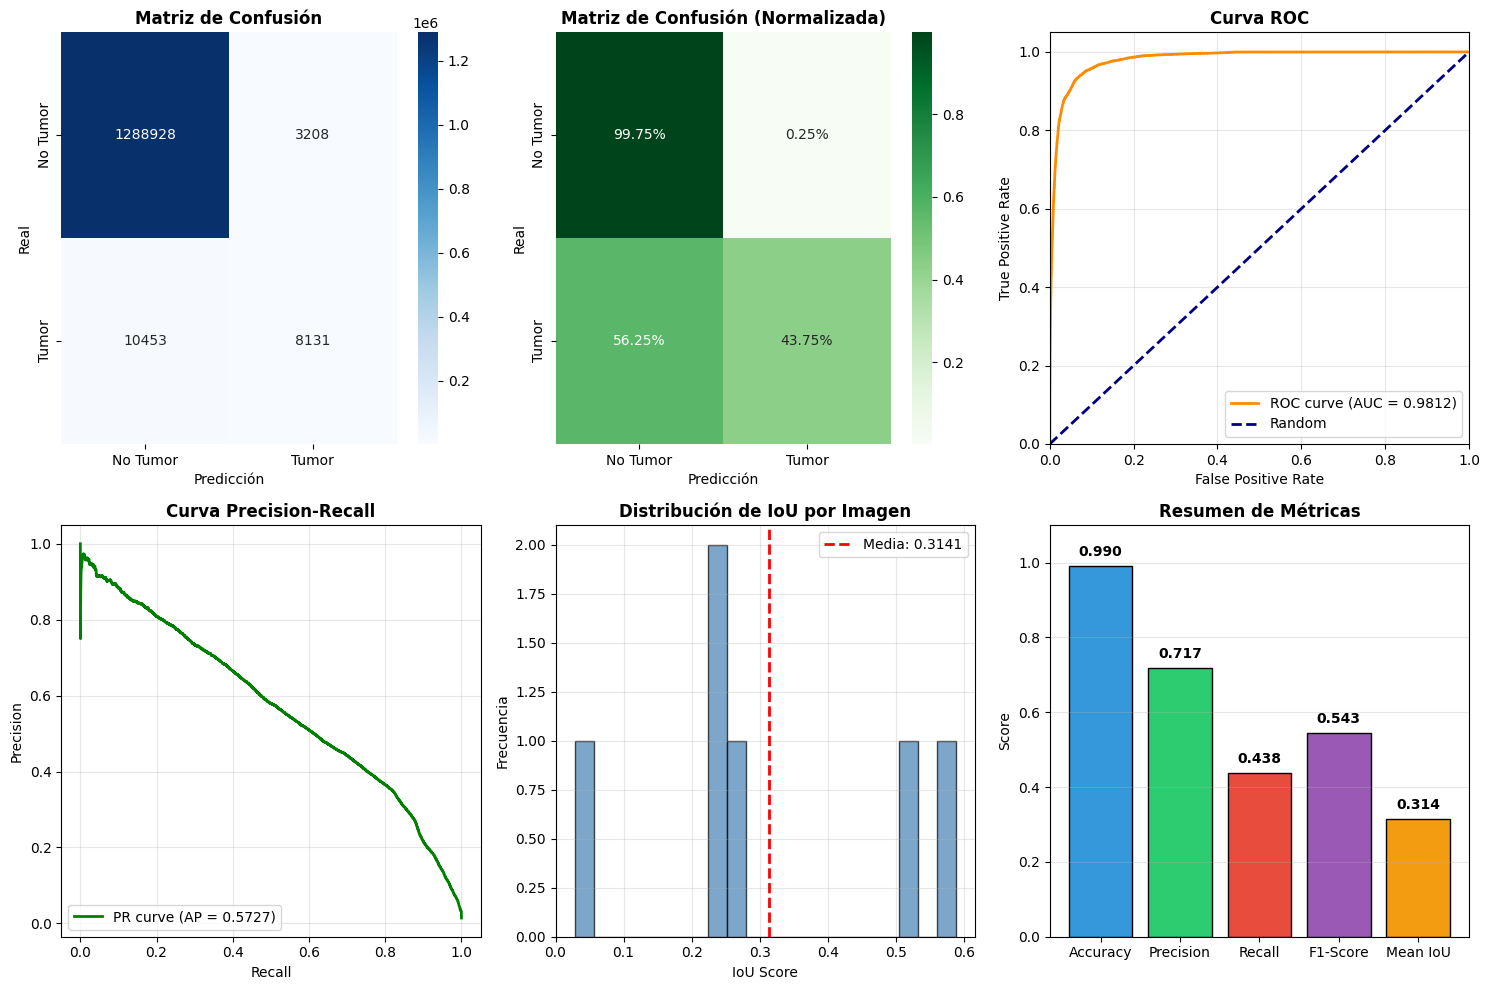


IMPORTANCIA DE CARACTERÍSTICAS (Random Forest)


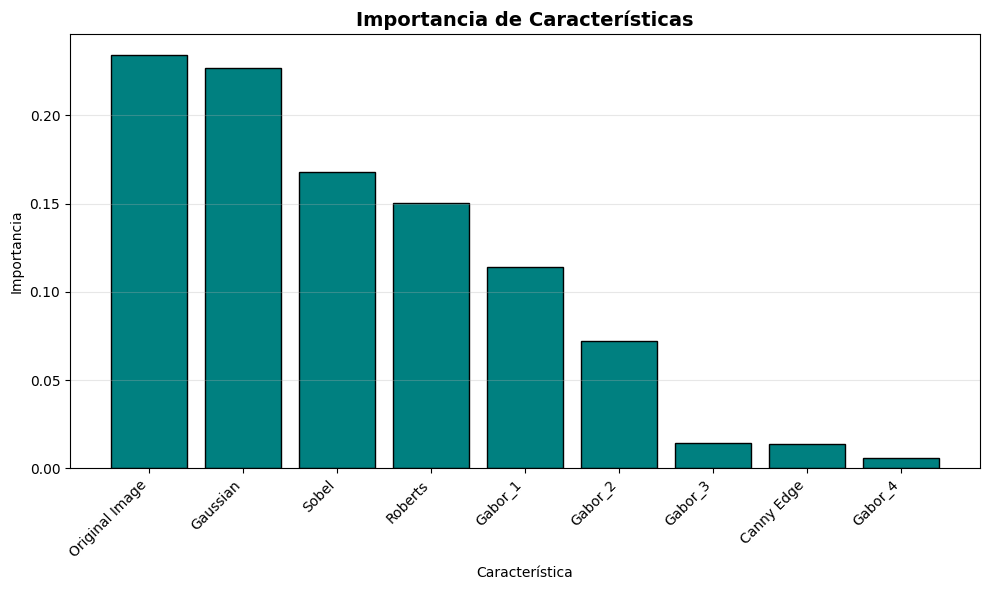


Ranking de características:
  1. Original Image: 0.2344
  2. Gaussian: 0.2268
  3. Sobel: 0.1677
  4. Roberts: 0.1504
  5. Gabor_1: 0.1141
  6. Gabor_2: 0.0723
  7. Gabor_3: 0.0143
  8. Canny Edge: 0.0141
  9. Gabor_4: 0.0060

✅ Evaluación completada.


In [ ]:
# ==========================================
# EVALUACIÓN Y MÉTRICAS DEL MODELO
# ==========================================
%matplotlib inline


print("--- Evaluando modelo en conjunto de test ---")

# Usamos imágenes de test para evaluar
test_imgs_eval = image_paths[subset_size:subset_size+20]  # 20 imágenes de test
test_masks_eval = mask_paths[subset_size:subset_size+20]

# Listas para almacenar predicciones y ground truth
all_y_true = []
all_y_pred = []
all_y_proba = []  # Probabilidades para ROC
iou_scores = []

for img_path, mask_path in tqdm(zip(test_imgs_eval, test_masks_eval), total=len(test_imgs_eval), desc="Evaluando"):
    if not os.path.exists(mask_path): continue
    
    img = cv2.imread(img_path, 0)
    gt_mask = cv2.imread(mask_path, 0) // 255
    
    # Extraer características y predecir
    df_features = extract_features(img)
    prediction_flat = model.predict(df_features)
    prediction_proba = model.predict_proba(df_features)[:, 1]  # Probabilidad de clase 1 (tumor)
    
    # Limpiar predicción
    prediction_mask = prediction_flat.reshape(img.shape)
    kernel = np.ones((3,3), np.uint8)
    prediction_cleaned = cv2.morphologyEx(prediction_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    
    # Almacenar resultados
    all_y_true.extend(gt_mask.flatten())
    all_y_pred.extend(prediction_cleaned.flatten())
    all_y_proba.extend(prediction_proba)
    
    # IoU por imagen
    if np.sum(gt_mask) > 0:  # Solo si hay tumor real
        iou = calculate_iou(gt_mask, prediction_cleaned)
        iou_scores.append(iou)

# Convertir a arrays
y_true = np.array(all_y_true)
y_pred = np.array(all_y_pred)
y_proba = np.array(all_y_proba)

# ==========================================
# 1. MÉTRICAS BÁSICAS
# ==========================================
print("\n" + "="*50)
print("MÉTRICAS DE CLASIFICACIÓN (PÍXEL A PÍXEL)")
print("="*50)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
mean_iou = np.mean(iou_scores) if iou_scores else 0

print(f"\n📊 Accuracy:  {accuracy:.4f}")
print(f"📊 Precision: {precision:.4f}")
print(f"📊 Recall:    {recall:.4f}")
print(f"📊 F1-Score:  {f1:.4f}")
print(f"📊 Mean IoU:  {mean_iou:.4f}")

# ==========================================
# 2. REPORTE DE CLASIFICACIÓN
# ==========================================
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

# ==========================================
# 3. VISUALIZACIONES
# ==========================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 3.1 Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
axes[0, 0].set_title('Matriz de Confusión', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicción')
axes[0, 0].set_ylabel('Real')

# 3.2 Matriz de Confusión Normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[0, 1],
            xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
axes[0, 1].set_title('Matriz de Confusión (Normalizada)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicción')
axes[0, 1].set_ylabel('Real')

# 3.3 Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)
axes[0, 2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0, 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0, 2].set_xlim([0.0, 1.0])
axes[0, 2].set_ylim([0.0, 1.05])
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('Curva ROC', fontsize=12, fontweight='bold')
axes[0, 2].legend(loc="lower right")
axes[0, 2].grid(True, alpha=0.3)

# 3.4 Curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
avg_precision = average_precision_score(y_true, y_proba)
axes[1, 0].plot(recall_curve, precision_curve, color='green', lw=2, 
                label=f'PR curve (AP = {avg_precision:.4f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Curva Precision-Recall', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc="lower left")
axes[1, 0].grid(True, alpha=0.3)

# 3.5 Distribución de IoU por imagen
axes[1, 1].hist(iou_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(mean_iou, color='red', linestyle='--', lw=2, label=f'Media: {mean_iou:.4f}')
axes[1, 1].set_xlabel('IoU Score')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de IoU por Imagen', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 3.6 Barras de métricas principales
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Mean IoU']
metrics_values = [accuracy, precision, recall, f1, mean_iou]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
bars = axes[1, 2].bar(metrics_names, metrics_values, color=colors, edgecolor='black')
axes[1, 2].set_ylim(0, 1.1)
axes[1, 2].set_title('Resumen de Métricas', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Score')
# Añadir valores encima de las barras
for bar, val in zip(bars, metrics_values):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ==========================================
# 4. IMPORTANCIA DE CARACTERÍSTICAS
# ==========================================
print("\n" + "="*50)
print("IMPORTANCIA DE CARACTERÍSTICAS (Random Forest)")
print("="*50)

feature_names = X.columns.tolist()
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características', fontsize=14, fontweight='bold')
plt.bar(range(len(importances)), importances[indices], color='teal', edgecolor='black')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Tabla de importancias
print("\nRanking de características:")
for i, idx in enumerate(indices):
    print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

print("\n✅ Evaluación completada.")

## Parte 2

--- Iniciando análisis por paciente (Parte 2) ---


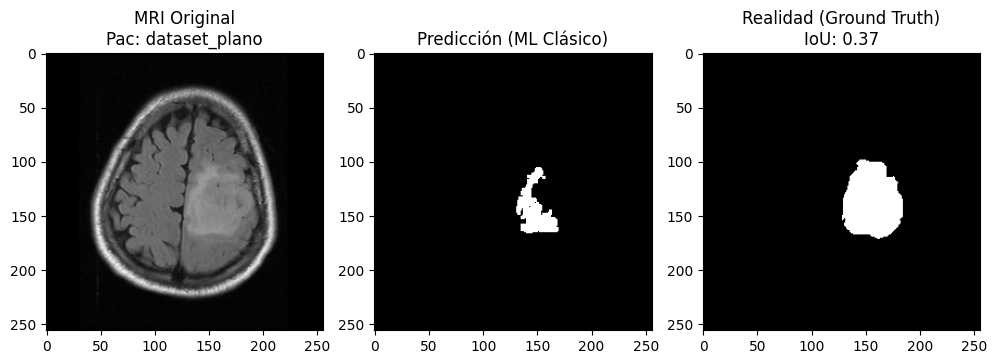

c:\Users\gjbet\Desktop\7e\apc\Tumor-Tracer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Resultados Agrupados por Paciente ---
Paciente: dataset_plano | Promedio IoU: 0.0440 | Slices con tumor detectados: 7


c:\Users\gjbet\Desktop\7e\apc\Tumor-Tracer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [4]:
# ==========================================
# PARTE 2: AGRUPACIÓN POR PACIENTE Y ANÁLISIS
# ==========================================

print("--- Iniciando análisis por paciente (Parte 2) ---")

# Diccionario para guardar resultados: { 'Patient_ID': [ {datos_slice_1}, {datos_slice_2} ] }
patients_data = {}

# Usamos algunas imágenes de prueba que el modelo NO haya visto
test_imgs = image_paths[subset_size:subset_size+10] 
test_masks = mask_paths[subset_size:subset_size+10]

for img_path, mask_path in zip(test_imgs, test_masks):
    if not os.path.exists(mask_path): continue

    # 1. Obtener ID del paciente desde la ruta
    # Estructura típica: .../TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
    # El ID del paciente suele ser la carpeta padre
    patient_id = os.path.basename(os.path.dirname(img_path))
    filename = os.path.basename(img_path)

    # 2. Cargar imagen y verdad terreno (Ground Truth)
    img = cv2.imread(img_path, 0)
    gt_mask = cv2.imread(mask_path, 0) // 255

    # 3. Predecir con el modelo de ML Clásico
    df_features = extract_features(img)
    prediction_flat = model.predict(df_features)
    prediction_mask = prediction_flat.reshape(img.shape)

    # 4. Limpieza (Morfología matemática)
    # Importante en ML clásico para quitar ruido "pimienta"
    kernel = np.ones((3,3), np.uint8)
    prediction_cleaned = cv2.morphologyEx(prediction_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # 5. Obtener Contornos
    # Contorno Predicho
    pred_contours = get_contours(prediction_cleaned)
    # Contorno Real (Ground Truth)
    gt_contours = get_contours(gt_mask)

    # 6. Comparación (IoU)
    iou = calculate_iou(gt_mask, prediction_cleaned)

    # 7. Guardar en estructura de datos
    if patient_id not in patients_data:
        patients_data[patient_id] = []

    patients_data[patient_id].append({
        'filename': filename,
        'iou': iou,
        'has_tumor_pred': 1 if np.sum(prediction_cleaned) > 0 else 0,
        'has_tumor_real': 1 if np.sum(gt_mask) > 0 else 0,
        'pred_contours_count': len(pred_contours)
    })

    # Visualización de un ejemplo (Opcional)
    if iou > 0.1 and iou < 0.9: # Mostrar casos interesantes
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 3, 1)
        plt.title(f"MRI Original\nPac: {patient_id}")
        plt.imshow(img, cmap='gray')
        
        plt.subplot(1, 3, 2)
        plt.title("Predicción (ML Clásico)")
        plt.imshow(prediction_cleaned, cmap='gray')
        
        plt.subplot(1, 3, 3)
        plt.title(f"Realidad (Ground Truth)\nIoU: {iou:.2f}")
        plt.imshow(gt_mask, cmap='gray')
        
        plt.tight_layout()
        plt.show()
        # Solo mostramos uno y rompemos el bucle de visualización para no llenar la pantalla
        # break 

# ==========================================
# RESUMEN POR PACIENTE
# ==========================================
print("\n--- Resultados Agrupados por Paciente ---")
for pid, slices in patients_data.items():
    avg_iou = np.mean([s['iou'] for s in slices])
    tumor_slices_detected = sum([s['has_tumor_pred'] for s in slices])
    print(f"Paciente: {pid} | Promedio IoU: {avg_iou:.4f} | Slices con tumor detectados: {tumor_slices_detected}")